In [1]:
import psycopg2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
warnings.simplefilter('ignore')
pd.options.display.max_columns = 300
sns.set_style('darkgrid')

In [2]:
#connect SQL
conn = psycopg2.connect(database='usaspendingdb', user='postgres', password='Fatih123', host='127.0.0.1', port='5432')

In [3]:
sql_cols = ('federal_action_obligation, '
            'base_and_exercised_options_value, '
            'base_and_all_options_value, '
            'awarding_sub_agency_name, '
            'awarding_office_name, '
            'funding_sub_agency_name, '
            'funding_office_name, '
            'primary_place_of_performance_state_code, '
            'award_or_idv_flag, '
            'award_type, '
            'type_of_contract_pricing, '
            'dod_claimant_program_description, '
            'type_of_set_aside_code, '
            'contract_bundling, '
            'national_interest_action, '
            'gfe_gfp, '
            'contract_financing, '
            'portfolio_group, '
            'product_or_service_code_description, '
            'naics_bucket_title, '
            'naics_description'
            )

In [4]:
#Create DF
df = pd.read_sql_query('SELECT ' + sql_cols + ' FROM consolidated_data_filtered_bucketed', con=conn)
df.shape

(35414, 21)

In [5]:
#Check if there is any null in DF.
df.isnull().sum()

federal_action_obligation                     0
base_and_exercised_options_value              0
base_and_all_options_value                    0
awarding_sub_agency_name                      0
awarding_office_name                          0
funding_sub_agency_name                       0
funding_office_name                          43
primary_place_of_performance_state_code       0
award_or_idv_flag                             0
award_type                                    0
type_of_contract_pricing                      0
dod_claimant_program_description              1
type_of_set_aside_code                      414
contract_bundling                             0
national_interest_action                      0
gfe_gfp                                       0
contract_financing                            0
portfolio_group                               0
product_or_service_code_description           0
naics_bucket_title                         7870
naics_description                       

In [6]:
#Drop null rows from 'type_of_set_aside_code' column.
df = df[pd.notnull(df['type_of_set_aside_code'])]
df.shape

(35000, 21)

In [7]:
def set_aside(c):
    if c['type_of_set_aside_code'] == 'NONE':
        return 0
    else:
        return 1

In [8]:
#Create column name 'set_aside' and apply function to populate rows with 0 or 1.
df['set_aside'] = df.apply(set_aside, axis=1)

In [9]:
def contract_value(c):
    if c['base_and_exercised_options_value'] > 0:
        return c['base_and_exercised_options_value']
    elif c['base_and_all_options_value'] > 0:
        return c['base_and_all_options_value']
    elif c['federal_action_obligation'] > 0:
        return c['federal_action_obligation'] 
    else:
        return 0

In [10]:
df['contract_value'] = df.apply(contract_value, axis=1)

In [11]:
#Drop columns that we dont need anymore.
df = df.drop(['type_of_set_aside_code','base_and_exercised_options_value','base_and_all_options_value',
             'federal_action_obligation'], axis=1)

In [12]:
df = df.dropna()
df.shape

(27246, 19)

In [13]:
df = pd.get_dummies(df)

In [14]:
from sklearn.model_selection import train_test_split, cross_val_score
from yellowbrick.classifier import ClassificationReport
from sklearn.ensemble import RandomForestClassifier

In [15]:
X = df.drop(['set_aside'], axis=1)

In [16]:
X

,contract_value,awarding_sub_agency_name_DEFENSE ADVANCED RESEARCH PROJECTS AGENCY (DARPA),awarding_sub_agency_name_DEFENSE COMMISSARY AGENCY (DECA),awarding_sub_agency_name_DEFENSE CONTRACT MANAGEMENT AGENCY (DCMA),awarding_sub_agency_name_DEFENSE COUNTERINTELLIGENCE AND SECURITY AGENCY,awarding_sub_agency_name_DEFENSE FINANCE AND ACCOUNTING SERVICE (DFAS),awarding_sub_agency_name_DEFENSE HEALTH AGENCY (DHA),awarding_sub_agency_name_DEFENSE HUMAN RESOURCES ACTIVITY,awarding_sub_agency_name_DEFENSE INFORMATION SYSTEMS AGENCY (DISA),awarding_sub_agency_name_DEFENSE LOGISTICS AGENCY,awarding_sub_agency_name_DEFENSE MEDIA ACTIVITY (DMA),awarding_sub_agency_name_DEFENSE MICROELECTRONICS ACTIVITY (DMEA),awarding_sub_agency_name_DEFENSE SECURITY COOPERATION AGENCY,awarding_sub_agency_name_DEFENSE THREAT REDUCTION AGENCY (DTRA),awarding_sub_agency_name_DEPT OF DEFENSE EDUCATION ACTIVITY (DODEA),awarding_sub_agency_name_JOINT IMPROVISED EXPLOSIVE DEVICE DEFEAT ORGANIZATION (JIEDDO),awarding_sub_agency_name_JOINT IMPROVISED EXPLOSIVE DEVICE DEFEAT ORGANIZATION (JIEDDO),awarding_sub_agency_name_MISSILE DEFENSE AGENCY (MDA),awarding_sub_agency_name_U.S. SPECIAL OPERATIONS COMMAND (USSOCOM),awarding_sub_agency_name_UNIFORMED SERVICES UNIVERSITY OF THE HEALTH SCIENCES (USUHS),awarding_sub_agency_name_USTRANSCOM,awarding_sub_agency_name_WASHINGTON HEADQUARTERS SERVICES (WHS),awarding_office_name_CONTRACTING OPERATIONS DIVISION,awarding_office_name_DCMA AIMO - ST AUGUSTINE,awarding_office_name_DCMA AIMO ST AUGUSTINE,awarding_office_name_DCMA APO KELLY SAN ANTONIO,awarding_office_name_DCMA BOEING,awarding_office_name_DCSO COLUMBUS,awarding_office_name_DCSO FORT BELVOIR,awarding_office_name_DCSO NEW CUMBERLAND,awarding_office_name_DCSO PHILADELPHIA,awarding_office_name_DCSO RICHMOND,awarding_office_name_DCSO-NEW CUMBERLAND,awarding_office_name_DCSO-P NEW CUMBERLAND,awarding_office_name_DCSO-P/HARRISBURG,awarding_office_name_DDESS AREA SERVICE CENTER,awarding_office_name_DEF ADVANCED RESEARCH PROJECTS AGCY,awarding_office_name_DEFENSE CI AND SECURITY AGENCY,awarding_office_name_DEFENSE COMMISSARY AGENCY,awarding_office_name_DEFENSE CONTRACT MANAGEMENT AGENCY,awarding_office_name_DEFENSE CONTRACT MANAGMENT OFFICE,awarding_office_name_DEFENSE FINANCE AND ACCOUNTING SVC,awarding_office_name_DEFENSE HEALTH AGENCY,awarding_office_name_DEFENSE HEALTH AGENCY - AURORA,awarding_office_name_DEFENSE HEALTH AGENCY - FALLS CHURCH,awarding_office_name_DEFENSE HUMAN RESOURCES ACTIVITY,awarding_office_name_DEFENSE INFORMATION SYSTEMS AGENCY,awarding_office_name_DEFENSE INFORMATION SYSTEMS ANGENCY,awarding_office_name_DEFENSE MICROELECTRONICS ACTIVITY,awarding_office_name_DEFENSE SECURITY COOPERATION AGENCY,awarding_office_name_DEFENSE THREAT REDUCTION AGENCY,awarding_office_name_DES DSCP CONTRACTING SERVICES OFC,awarding_office_name_DISA/DITCO EUROPE,awarding_office_name_DITCO-PAC,awarding_office_name_DITCO-SCOTT,awarding_office_name_DLA DOCUMENT SERVICES,awarding_office_name_DLA ENERGY,"awarding_office_name_DLA AVIATION AT WARNER ROBINS, GA",awarding_office_name_DLA CONTRACTING SERVICES OFFICE,awarding_office_name_DLA CONTRACTING SVCS OFF COLUMBUS,awarding_office_name_DLA DISPOSITION SERVICES - EBS,awarding_office_name_DLA DISPOSITION SERVICES J-761,awarding_office_name_DLA DISPOSTION SERVICE - EBS,awarding_office_name_DLA DISPOSTION SERVICES - PACIFIC,awarding_office_name_DLA DISTRIBUTION,awarding_office_name_DLA ENERGY,awarding_office_name_DLA ENERGY AEROSPACE ENRGY-DLAE-M,awarding_office_name_DLA MARITIME - NORFOLK,awarding_office_name_DLA MARITIME - PUGET SOUND,awarding_office_name_DLA STRATEGIC MATERIALS,awarding_office_name_DLA TROOP SUPPORT,awarding_office_name_DLA TROOP SUPPORT EUR&AF,awarding_office_name_DMA RIVERSIDE,awarding_office_name_DOD EDUCATION ACTIVITY,awarding_office_name_DODDS EUROPE DIRECTOR'S OFFICE,awarding_office_name_DODDS PACIFIC DIRECTOR'S OFFICE,awarding_office_name_HQ DEFENSE MEDIA ACTIVITY,awarding_office_name_HQ USASOC,awarding_

In [17]:
y = df['set_aside']

In [18]:
y

0        0
1        0
3        1
4        0
7        0
        ..
35350    1
35352    0
35355    0
35364    1
35367    0
Name: set_aside, Length: 27246, dtype: int64

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [20]:
model = RandomForestClassifier(n_estimators=17)

In [21]:
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=17,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [22]:
predictions = model.predict(X_test)

In [23]:
classes = ['None', 'Set Aside']

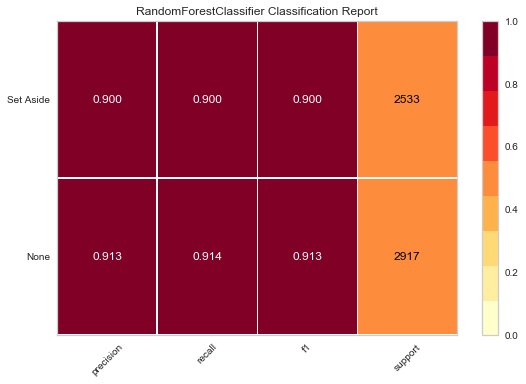

In [24]:
visualizer = ClassificationReport(model, classes=classes, support=True)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

In [52]:
#Test Single row
a = X.iloc[2:3,:]

In [53]:
a.shape

(1, 1551)

In [54]:
pred = model.predict(a)

In [55]:
print(pred)

[1]


### Second Model for Set Aside 

In [56]:
df1 = pd.read_sql_query('SELECT ' + sql_cols + ' FROM consolidated_data_filtered_bucketed', con=conn)

In [57]:
none_set_asides = df1[df1['type_of_set_aside_code']== 'NONE'].index

In [58]:
#drop all the set_aside = NONE
df1 = df1.drop(none_set_asides, axis=0)

In [59]:
def contract_value(c):
    if c['base_and_exercised_options_value'] > 0:
        return c['base_and_exercised_options_value']
    elif c['base_and_all_options_value'] > 0:
        return c['base_and_all_options_value']
    elif c['federal_action_obligation'] > 0:
        return c['federal_action_obligation'] 
    else:
        return 0

In [60]:
df1['contract_value'] = df1.apply(contract_value, axis=1)

In [61]:
df1['set_aside_number'] = df1['type_of_set_aside_code'].map({'SBA':1, 'WOSB':2, '8A':3, '8AN':4, 'SDVOSBC':5,'HZC':6,
                                                          'SBP':7, 'SDVOSBS':8, 'EDWOSB':9, 'WOSBSS':10, 'HZS':11, 'ISBEE':12})

In [62]:
#Drop columns that we dont need anymore.
df1 = df1.drop(['type_of_set_aside_code','base_and_exercised_options_value','base_and_all_options_value',
             'federal_action_obligation'], axis=1)

In [63]:
df1 = df1.dropna()
df1.shape

(12523, 19)

In [64]:
df1 = pd.get_dummies(df1)
df1.shape

(12523, 918)

In [65]:
X1 = df1.drop(['set_aside_number'], axis=1)

In [66]:
y1 = df1['set_aside_number']

In [67]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.33, random_state=42)

In [68]:
model1 = RandomForestClassifier(n_estimators=17)

In [69]:
classes1 = ['SBA', 'WOSB', '8A', '8AN', 'SDVOSBC','HZC', 'SBP', 'SDVOSBS', 'EDWOSB', 'WOSBSS', 'HZS', 'ISBEE']

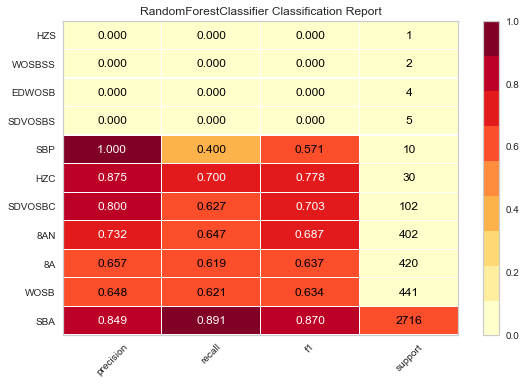

In [70]:
for i in pred:
    if i == 1:
        visualizer1 = ClassificationReport(model1, classes=classes1, support=True)
        visualizer1.fit(X1_train, y1_train)
        visualizer1.score(X1_test, y1_test)
        visualizer1.show()
    else :
        print('Not Set Aside')

In [71]:
y1

3         3.0
8         5.0
13        1.0
23        1.0
32        1.0
         ... 
35343     1.0
35346    10.0
35348     5.0
35350     4.0
35364     1.0
Name: set_aside_number, Length: 12523, dtype: float64

In [72]:
#Test single row
b = X1.iloc[:1,:]

In [73]:
b

,contract_value,awarding_sub_agency_name_DEFENSE ADVANCED RESEARCH PROJECTS AGENCY (DARPA),awarding_sub_agency_name_DEFENSE COMMISSARY AGENCY (DECA),awarding_sub_agency_name_DEFENSE CONTRACT MANAGEMENT AGENCY (DCMA),awarding_sub_agency_name_DEFENSE COUNTERINTELLIGENCE AND SECURITY AGENCY,awarding_sub_agency_name_DEFENSE FINANCE AND ACCOUNTING SERVICE (DFAS),awarding_sub_agency_name_DEFENSE HEALTH AGENCY (DHA),awarding_sub_agency_name_DEFENSE HUMAN RESOURCES ACTIVITY,awarding_sub_agency_name_DEFENSE INFORMATION SYSTEMS AGENCY (DISA),awarding_sub_agency_name_DEFENSE LOGISTICS AGENCY,awarding_sub_agency_name_DEFENSE MEDIA ACTIVITY (DMA),awarding_sub_agency_name_DEFENSE MICROELECTRONICS ACTIVITY (DMEA),awarding_sub_agency_name_DEFENSE SECURITY COOPERATION AGENCY,awarding_sub_agency_name_DEFENSE THREAT REDUCTION AGENCY (DTRA),awarding_sub_agency_name_DEPT OF DEFENSE EDUCATION ACTIVITY (DODEA),awarding_sub_agency_name_JOINT IMPROVISED EXPLOSIVE DEVICE DEFEAT ORGANIZATION (JIEDDO),awarding_sub_agency_name_JOINT IMPROVISED EXPLOSIVE DEVICE DEFEAT ORGANIZATION (JIEDDO),awarding_sub_agency_name_MISSILE DEFENSE AGENCY (MDA),awarding_sub_agency_name_U.S. SPECIAL OPERATIONS COMMAND (USSOCOM),awarding_sub_agency_name_UNIFORMED SERVICES UNIVERSITY OF THE HEALTH SCIENCES (USUHS),awarding_sub_agency_name_USTRANSCOM,awarding_sub_agency_name_WASHINGTON HEADQUARTERS SERVICES (WHS),awarding_office_name_CONTRACTING OPERATIONS DIVISION,awarding_office_name_DCSO COLUMBUS,awarding_office_name_DCSO FORT BELVOIR,awarding_office_name_DCSO NEW CUMBERLAND,awarding_office_name_DCSO PHILADELPHIA,awarding_office_name_DCSO RICHMOND,awarding_office_name_DCSO-NEW CUMBERLAND,awarding_office_name_DCSO-P NEW CUMBERLAND,awarding_office_name_DCSO-P/HARRISBURG,awarding_office_name_DDESS AREA SERVICE CENTER,awarding_office_name_DEF ADVANCED RESEARCH PROJECTS AGCY,awarding_office_name_DEFENSE CI AND SECURITY AGENCY,awarding_office_name_DEFENSE COMMISSARY AGENCY,awarding_office_name_DEFENSE CONTRACT MANAGEMENT AGENCY,awarding_office_name_DEFENSE CONTRACT MANAGMENT OFFICE,awarding_office_name_DEFENSE FINANCE AND ACCOUNTING SVC,awarding_office_name_DEFENSE HEALTH AGENCY,awarding_office_name_DEFENSE HEALTH AGENCY - AURORA,awarding_office_name_DEFENSE HEALTH AGENCY - FALLS CHURCH,awarding_office_name_DEFENSE HUMAN RESOURCES ACTIVITY,awarding_office_name_DEFENSE INFORMATION SYSTEMS AGENCY,awarding_office_name_DEFENSE INFORMATION SYSTEMS ANGENCY,awarding_office_name_DEFENSE MICROELECTRONICS ACTIVITY,awarding_office_name_DEFENSE SECURITY COOPERATION AGENCY,awarding_office_name_DEFENSE THREAT REDUCTION AGENCY,awarding_office_name_DES DSCP CONTRACTING SERVICES OFC,awarding_office_name_DISA/DITCO EUROPE,awarding_office_name_DITCO-PAC,awarding_office_name_DITCO-SCOTT,awarding_office_name_DLA DOCUMENT SERVICES,awarding_office_name_DLA ENERGY,"awarding_office_name_DLA AVIATION AT WARNER ROBINS, GA",awarding_office_name_DLA CONTRACTING SERVICES OFFICE,awarding_office_name_DLA CONTRACTING SVCS OFF COLUMBUS,awarding_office_name_DLA DISPOSITION SERVICES - EBS,awarding_office_name_DLA DISPOSTION SERVICE - EBS,awarding_office_name_DLA DISPOSTION SERVICES - PACIFIC,awarding_office_name_DLA DISTRIBUTION,awarding_office_name_DLA ENERGY,awarding_office_name_DLA ENERGY AEROSPACE ENRGY-DLAE-M,awarding_office_name_DLA STRATEGIC MATERIALS,awarding_office_name_DMA RIVERSIDE,awarding_office_name_DOD EDUCATION ACTIVITY,awarding_office_name_DODDS EUROPE DIRECTOR'S OFFICE,awarding_office_name_DODDS PACIFIC DIRECTOR'S OFFICE,awarding_office_name_HQ DEFENSE MEDIA ACTIVITY,awarding_office_name_HQ USASOC,awarding_office_name_IT CONTRACTING DIVISION - PL83,awarding_office_name_J7 WHITE HOUSE COMM AGENCY,awarding_office_name_JOINT IED DEFEAT ORGANIZATION,awarding_office_name_MARSOC CONTRACTING M67906,awarding_office_name_MISSILE DEFENSE AGENCY (MDA),awarding_office_name_NAVAL SPECIAL WARFARE COMMAND,awarding_office_name_SPECIAL OPERATIONS FORCES SPT ACTY,awarding_office_name_USSOCOM REGIONAL CONTRACTING OFFI

In [74]:
set_aside_name = model1.predict(b)

In [75]:
print(set_aside_name)

[1.]


In [76]:
for j in set_aside_name:
    if j == 1:
        print('SBA')
    elif j == 2:
        print('WOSB')
    elif j == 3:
        print('8A')
    elif j == 4:
        print('8AN')
    elif j == 5:
        print('SDVOSBC')
    elif j == 6:
        print('HZC')
    elif j == 7:
        print('SBP')
    elif j == 8:
        print('SDVOSBS')
    elif j == 9:
        print('EDWOSB')
    elif j == 10:
        print('WOSBSS')
    elif j == 11:
        print('HZS')
    else:
        'ISBEE'

SBA
